<a href="https://colab.research.google.com/github/MohdIstiaqHossainJunaid/Deep-Learning-Approach-to-Cataract-Prediction/blob/main/CSE465_Project(Cataract_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Deep learning techniques to classifies Eye Diseases(cataract)**

## Group members:
1. **Mohd Istiaq Hossain Junaid**- **1821577642**
2. Tamalika Bakshi - 1812469042

## **Dataset**
Collected from Kaggle.
Link: https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k

Already preprocessed


#Data load ! 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Playing with Data/preprocessed_images'):
    for filename in filenames:
        pass
df = pd.read_csv("/content/drive/MyDrive/Playing with Data/full_df.csv")
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
print(left_cataract[:10])
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
print(right_cataract[:15])

['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']


In [ ]:

print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 600


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/MyDrive/Playing with Data/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [01:14<00:00,  7.93it/s] 


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [02:13<00:00,  4.51it/s]


In [ ]:
len(dataset)

1188

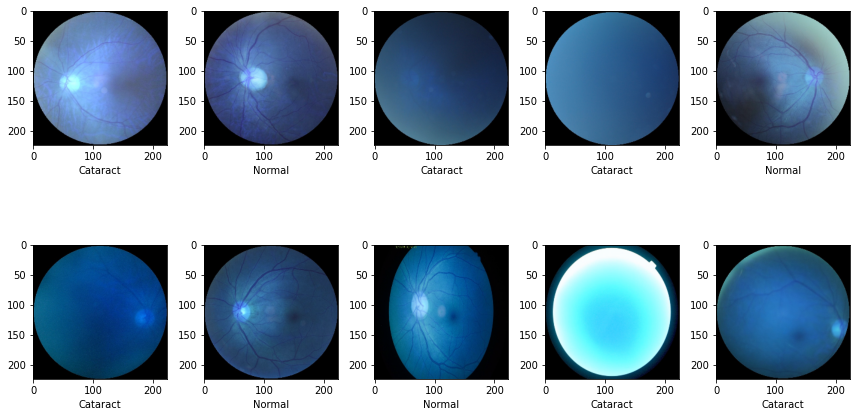

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2)
x_val,x_test,y_val,y_test = train_test_split(x_val,y_val,test_size=0.5)
x_train = x_train.astype("float32") 
x_test = x_test.astype("float32") 
print(len(x_train))

print(len(x_val))
print(len(x_test))

950
119
119


## Applying various Model

**VGG16**(Pretrained Model)

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

vgg = VGG16(include_top=False,input_shape=(224,224,3),pooling='avg',weights='imagenet') #important

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense

model = Sequential()
model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"]) ##important

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("VGG16.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
30/30 [==============================] - 64s 795ms/step - loss: 0.3619 - accuracy: 0.8411 - val_loss: 0.2831 - val_accuracy: 0.9160

Epoch 00001: val_accuracy improved from -inf to 0.91597, saving model to VGG16.h5
Epoch 2/10
30/30 [==============================] - 8s 277ms/step - loss: 0.1937 - accuracy: 0.9326 - val_loss: 0.2630 - val_accuracy: 0.9328

Epoch 00002: val_accuracy improved from 0.91597 to 0.93277, saving model to VGG16.h5
Epoch 3/10
30/30 [==============================] - 8s 276ms/step - loss: 0.1870 - accuracy: 0.9337 - val_loss: 0.2420 - val_accuracy: 0.9328

Epoch 00003: val_accuracy did not improve from 0.93277
Epoch 4/10
30/30 [==============================] - 8s 276ms/step - loss: 0.1692 - accuracy: 0.9442 - val_loss: 0.2244 - val_accuracy: 0.9328

Epoch 00004: val_accuracy did not improve from 0.93277
Epoch 5/10
30/30 [==============================] - 8s 277ms/step - loss: 0.1635 - accuracy: 0.9411 - val_loss: 0.2314 - val_accuracy: 0.9244

Epoch 0

In [ ]:
loss,accuracy = model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy) 

4/4 [==============================] - 1s 234ms/step - loss: 0.0543 - accuracy: 0.9832
loss: 0.05432501435279846
Accuracy: 0.9831932783126831


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_val)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        64
           1       0.98      0.98      0.98        55

    accuracy                           0.98       119
   macro avg       0.98      0.98      0.98       119
weighted avg       0.98      0.98      0.98       119



**ResNet50**(Pretrained Model)

In [ ]:
import tensorflow as tf
from keras.applications.resnet import ResNet50, preprocess_input
pretrained_model =tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),pooling='avg',weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in pretrained_model.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense

resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(layers.Dropout(rate=0.5))
resnet_model.add(Dense(128, activation='sigmoid'))
resnet_model.add(layers.Dropout(rate=0.2))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(layers.Dropout(0.1))
resnet_model.add(Flatten())
resnet_model.add(Dense(1,activation="sigmoid"))
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
resnet_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("ResNet50.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:

history = resnet_model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/10
30/30 [==============================] - 15s 342ms/step - loss: 0.2952 - accuracy: 0.8832 - val_loss: 0.2236 - val_accuracy: 0.9244

Epoch 00001: val_accuracy improved from -inf to 0.92437, saving model to ResNet50.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
30/30 [==============================] - 7s 245ms/step - loss: 0.1807 - accuracy: 0.9316 - val_loss: 0.2103 - val_accuracy: 0.9412

Epoch 00002: val_accuracy improved from 0.92437 to 0.94118, saving model to ResNet50.h5
Epoch 3/10
30/30 [==============================] - 7s 246ms/step - loss: 0.1851 - accuracy: 0.9232 - val_loss: 0.2200 - val_accuracy: 0.9244

Epoch 00003: val_accuracy did not improve from 0.94118
Epoch 4/10
30/30 [==============================] - 7s 245ms/step - loss: 0.1656 - accuracy: 0.9432 - val_loss: 0.1833 - val_accuracy: 0.9328

Epoch 00004: val_accuracy did not improve from 0.94118
Epoch 5/10
30/30 [==============================] - 7s 245ms/step - loss: 0.1508 - accuracy: 0.9389 - val_loss: 0.2202 - val_accuracy: 0.9244

Epoch 00005: val_accuracy did not improve from 0.94118
Epoch 6/10
30/30 [==============================] - 7s 245ms/step - loss: 0.1343 - accuracy: 0.9442 - val_loss: 0.1650 - val_accuracy: 0.9412

Epoch 00006: val_accuracy did no

In [ ]:
loss,accuracy = resnet_model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 2s 207ms/step - loss: 0.0869 - accuracy: 0.9664
loss: 0.086860790848732
Accuracy: 0.9663865566253662


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = resnet_model.predict(x_val)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        64
           1       1.00      0.93      0.96        55

    accuracy                           0.97       119
   macro avg       0.97      0.96      0.97       119
weighted avg       0.97      0.97      0.97       119



** InceptionV3 Model**(Pretrained)

In [ ]:
pretrained_model_2 =tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3),pooling='avg',weights='imagenet')


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pretrained_model_2.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense

Incep_model = Sequential()
Incep_model.add(pretrained_model_2)
Incep_model.add(Flatten())
Incep_model.add(Dense(1021,activation='relu'))
Incep_model.add(layers.Dropout(0.2))
Incep_model.add(Dense(1,activation='sigmoid'))
Incep_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1021)              2092029   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1021)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1022      
Total params: 23,895,835
Trainable params: 2,093,051
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
Incep_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("Incep_model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
history = Incep_model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),callbacks=[checkpoint,earlystop])

Epoch 1/10
30/30 [==============================] - 17s 349ms/step - loss: 14.0699 - accuracy: 0.6253 - val_loss: 2.5475 - val_accuracy: 0.7647

Epoch 00001: val_accuracy improved from -inf to 0.76471, saving model to Incep_model.h5
Epoch 2/10
30/30 [==============================] - 6s 192ms/step - loss: 1.0920 - accuracy: 0.8105 - val_loss: 0.6444 - val_accuracy: 0.8319

Epoch 00002: val_accuracy improved from 0.76471 to 0.83193, saving model to Incep_model.h5
Epoch 3/10
30/30 [==============================] - 6s 191ms/step - loss: 0.6405 - accuracy: 0.8442 - val_loss: 0.5451 - val_accuracy: 0.8235

Epoch 00003: val_accuracy did not improve from 0.83193
Epoch 4/10
30/30 [==============================] - 6s 190ms/step - loss: 0.3963 - accuracy: 0.8674 - val_loss: 0.6799 - val_accuracy: 0.7899

Epoch 00004: val_accuracy did not improve from 0.83193
Epoch 5/10
30/30 [==============================] - 6s 191ms/step - loss: 0.4238 - accuracy: 0.8579 - val_loss: 0.5465 - val_accuracy: 0.

In [ ]:
loss,accuracy = Incep_model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 2s 167ms/step - loss: 0.2115 - accuracy: 0.9160
loss: 0.21154943108558655
Accuracy: 0.9159663915634155


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = Incep_model.predict(x_val)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93        64
           1       0.98      0.84      0.90        55

    accuracy                           0.92       119
   macro avg       0.93      0.91      0.91       119
weighted avg       0.92      0.92      0.92       119



**VGG19**(Pretrained Model)

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
pretrained_model_3 =tf.keras.applications.VGG19(include_top=False,input_shape=(224,224,3),pooling='avg',weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in pretrained_model_3.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten,Dense

vvg19_model = Sequential()
vvg19_model.add(pretrained_model_3)
vvg19_model.add(Flatten())
vvg19_model.add(Dense(1021,activation='relu'))
vvg19_model.add(layers.Dropout(0.2))
vvg19_model.add(Dense(1,activation='sigmoid'))
vvg19_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1021)              523773    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1021)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1022      
Total params: 20,549,179
Trainable params: 524,795
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
vvg19_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vvg19_model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
history = vvg19_model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test),callbacks=[checkpoint,earlystop])

Epoch 1/10
30/30 [==============================] - 11s 340ms/step - loss: 0.5722 - accuracy: 0.9032 - val_loss: 0.3139 - val_accuracy: 0.9160

Epoch 00001: val_accuracy improved from -inf to 0.91597, saving model to vvg19_model.h5
Epoch 2/10
30/30 [==============================] - 10s 330ms/step - loss: 0.1764 - accuracy: 0.9432 - val_loss: 0.2162 - val_accuracy: 0.9496

Epoch 00002: val_accuracy improved from 0.91597 to 0.94958, saving model to vvg19_model.h5
Epoch 3/10
30/30 [==============================] - 10s 331ms/step - loss: 0.1603 - accuracy: 0.9495 - val_loss: 0.2013 - val_accuracy: 0.9412

Epoch 00003: val_accuracy did not improve from 0.94958
Epoch 4/10
30/30 [==============================] - 10s 330ms/step - loss: 0.1071 - accuracy: 0.9632 - val_loss: 0.1238 - val_accuracy: 0.9496

Epoch 00004: val_accuracy did not improve from 0.94958
Epoch 5/10
30/30 [==============================] - 10s 329ms/step - loss: 0.0850 - accuracy: 0.9684 - val_loss: 0.1600 - val_accuracy:

In [ ]:
loss,accuracy = vvg19_model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 1s 278ms/step - loss: 0.1111 - accuracy: 0.9748
loss: 0.11109554022550583
Accuracy: 0.9747899174690247


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = vvg19_model.predict(x_val)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        64
           1       0.95      1.00      0.97        55

    accuracy                           0.97       119
   macro avg       0.97      0.98      0.97       119
weighted avg       0.98      0.97      0.97       119



##ROC curve

In [ ]:
from tensorflow import keras
model4 = keras.models.load_model('/content/drive/MyDrive/Playing with Data/Created Model of CSE465/vvg19_model.h5')


In [ ]:
import sklearn.metrics as metrics

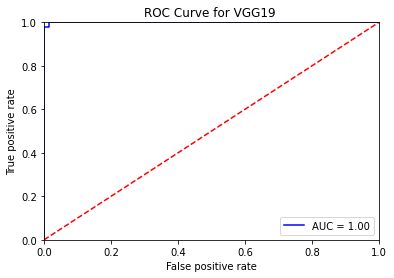

In [ ]:
predictions = model4.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_test, predictions)
auc_keras = metrics.auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, 'b', label = 'AUC = %0.2f' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for VGG19 ')
plt.show()

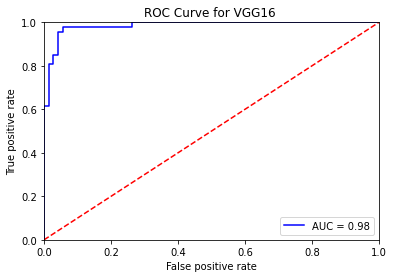

In [ ]:
predictions = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = metrics.roc_curve(y_test, predictions)
auc_keras = metrics.auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot(fpr_keras, tpr_keras, 'b', label = 'AUC = %0.2f' % auc_keras)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for VGG16 ')
plt.show()